# Hierarchical clustering
---

This is an example routine to perform hierarchical clustering on an IRIS-like raster.

## Modules

In [16]:
# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt

# Scipy
from scipy.stats import norm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Extras
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

## Functions

In [17]:
def gaussian(x, mu, sig):
    """
        Gaussian definition.
    """
    return (1.0/(sig*np.sqrt(2.0*np.pi)))*np.exp( -0.5*((x-mu)/sig)**2.0 )


def mgii_profiles(xx):
    """
        Function to create 8 artificial kind of Mg II h&k profiles 
        
    """
    wk0  = 2796.2
    wk1  = 2796.8
    wk2  = 2803.2
    wk3  = 2803.8
    wcc  = 2800.0

    sig1 = 0.2
    sig2 = 0.5
    sig3 = 0.1
    sigc = 2
    
    f1   = gaussian(xx, wk0, sig1) + gaussian(xx, wk1, sig1) + \
    gaussian(xx, wk2, sig1) + gaussian(xx, wk3, sig1) + gaussian(xx, wcc, sigc)
    f2   = gaussian(xx, wk0, sig2) + gaussian(xx, wk1, sig2) + \
    gaussian(xx, wk2, sig2) + gaussian(xx, wk3, sig2) + gaussian(xx, wcc, sigc)
    f3   = gaussian(xx, wk0, sig1) + gaussian(xx, wk1, sig2) + \
    gaussian(xx, wk2, sig1) + gaussian(xx, wk3, sig2) + gaussian(xx, wcc, sigc)
    f4   = gaussian(xx, wk0, sig2) + gaussian(xx, wk1, sig1) + \
    gaussian(xx, wk2, sig2) + gaussian(xx, wk3, sig1) + gaussian(xx, wcc, sigc)
    f5   = gaussian(xx, wk0, sig3) + gaussian(xx, wk1, sig3) + \
    gaussian(xx, wk2, sig3) + gaussian(xx, wk3, sig3) + gaussian(xx, wcc, sigc)
    f6   = gaussian(xx, wk0, sig1) + gaussian(xx, wk1, sig3) + \
    gaussian(xx, wk2, sig1) + gaussian(xx, wk3, sig3) + gaussian(xx, wcc, sigc)
    f7   = gaussian(xx, wk0, sig3) + 0.8*gaussian(xx, wk1, sig3) + \
    gaussian(xx, wk2, sig3) + 0.8*gaussian(xx, wk3, sig3) + gaussian(xx, wcc, sigc)
    f8   = gaussian(xx, wk0, sig3) + gaussian(xx, wk1, sig1) + \
    gaussian(xx, wk2, sig3) + gaussian(xx, wk3, sig1) + gaussian(xx, wcc, sigc)
    
    return np.stack((f1, f2, f3, f4, f5, f6, f7, f8))

##  Artificial IRIS raster

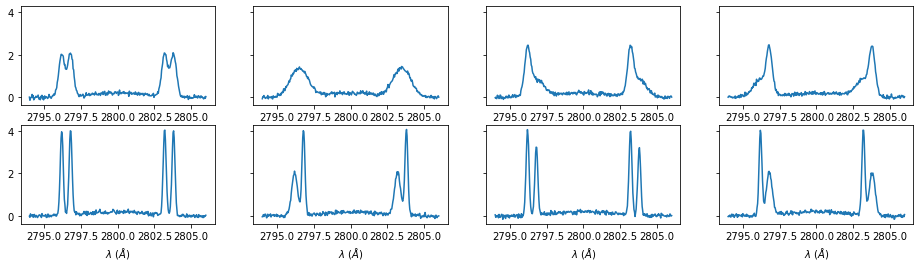

In [18]:
"""
    We create an artificial IRIS raster with eight kind of Mg II h&k profiles
"""
# 1. Wavelength aray and array with 8 kind of Mg II h&k profiles
nprof    = 8                           # Number of profiles [If you change it, you need to change mgii_profile routine]
nw       = 324                         # Number of elements for the wavelength array
wi       = 2794                        # Lower limit of the wavelength array
wf       = 2806                        # Upper limit of the wavelength array
iris_wl  = np.linspace(wi, wf, num=nw) # Wavelength array
ff       = mgii_profiles(iris_wl)      # Array with 8 different Mg II h&k profiles

# 2. Raster separating the 8 profiles in different regions and adding noise to each profile so they are not identical
nx       = 64                          # X size of the IRIS raster
xx       = np.arange(nx)               # Array for the X coordinate
ny       = 108                         # Y size of the IRIS raster
yy       = np.arange(ny)               # Array for the Y coordinate
raster_m = np.zeros((nx, ny, nw))      # IRIS raster
noise    = 0.05
ll       = -1
for ii in range(nx):
    if (ii % nprof == 0):
        ll+=1 
    for jj in range(ny):
        raster_m[ii,jj,:] = ff[ll] + noise*norm.ppf(np.random.rand(nw))


# 3. Plot an example of each kind of profile
nrow = 2    # Number of rows for the plots
ncol = 4    # Number of columns for the plots
fig, axs = plt.subplots(nrow,ncol,figsize=(16,4), facecolor='white', sharey=True)
for kk in range(nprof):
    axs.flat[kk].set_xlabel(r"$\lambda$ ($\AA$)")
    axs.flat[kk].plot(iris_wl,raster_m[nprof*kk,100,:])
plt.show()

## Hierarchical clustering

In [19]:
data = raster_m.reshape(raster_m.shape[0]*raster_m.shape[1],raster_m.shape[2])
Z    = linkage(data, 'ward', metric='euclidean')

## Dendogram and labels map

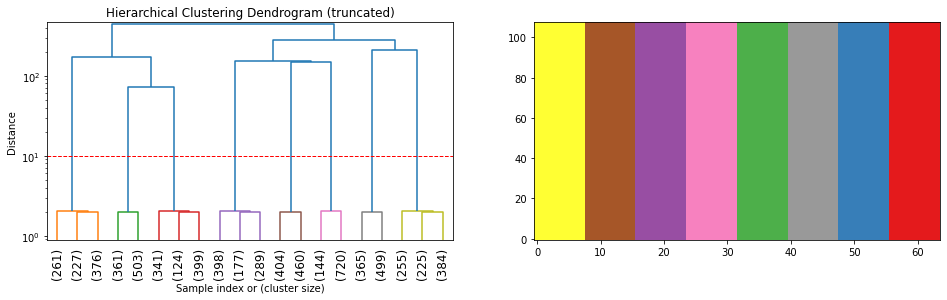

In [20]:
max_d   = 10 # Maximum distance to decide the number of clusters

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

#---------------------------------------------------------------------------------------------------
# DENDOGRAM
#---------------------------------------------------------------------------------------------------
mm = 0
ax.flat[mm].set_title('Hierarchical Clustering Dendrogram (truncated)')
ax.flat[mm].set_xlabel('Sample index or (cluster size)')
ax.flat[mm].set_ylabel('Distance')
ax.flat[mm].set_yscale("log")

im = dendrogram(
        Z,
        ax=ax.flat[mm],
        truncate_mode='lastp',  # show only the last p merged clusters
        p=20,                   # show only the last p merged clusters
        leaf_rotation=90.,
        leaf_font_size=12.,
        above_threshold_color='C0',
        color_threshold=max_d,
        show_contracted=False,  # to get a distribution impression in truncated branches
)
ax.flat[mm].axhline(max_d, color='red', lw=1, ls="dashed")

#---------------------------------------------------------------------------------------------------
# LABELS MAP FOR A GIVEN MAX_D
#---------------------------------------------------------------------------------------------------
mm = 1
clusters = fcluster(Z, max_d, criterion='distance')
clusters = clusters.reshape(raster_m.shape[0],raster_m.shape[1])
ax.flat[mm].pcolormesh(xx,yy,clusters.T,cmap="Set1")


plt.show()